# Neural Networks: Backpropagation with Pure Python

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 2

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- implement backpropagation in pure python

This is basically the code shown in the lecture, with a tiny bit of clean-up and extra comments.

### Imports: only numpy and matplotlib

In [328]:
# get the "numpy" library for linear algebra

# In the lecture videos, I do this:
#
# from numpy import *
#
# WARNING: It is generally considered bad
# programming style to "import *", as it
# can lead to confusion. For me, I
#  (1) ALWAYS import numpy
#  (2) NEVER import any other package in this * way
# Therefore, there is never confusion for me, and
# it makes my code a bit more readable (for me).
# However, since 99% of people are using the 
# syntax "import numpy as np" and then
# access "np.exp()" etc., you
# should probably also use "np" once you start
# exchanging code with others. I convert
# back to the np. syntax when I turn my
# converged code into a module.
#
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:

from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace, transpose
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=100 # highres display

# Backpropagation

## Implement backpropagation for a general (fully connected) network

In [329]:
def net_f_df(z): # calculate f(z) and f'(z)
    val=1/(1+exp(-z)) # sigmoid
    return(val,exp(-z)*(val**2)) # return both f and f'

In [330]:
def forward_step(y,w,b): # calculate values in next layer, from input y
    z=dot(y,w)+b # w=weights, b=bias vector for next layer
    return(net_f_df(z)) # apply nonlinearity and return result

In [331]:
def apply_net(y_in): # one forward pass through the network
    global Weights, Biases, NumLayers
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step
        df_layer[j]=df # store f'(z) [needed later in backprop]
        y_layer[j+1]=y # store f(z) [also needed in backprop]        
    return(y)

In [332]:
def apply_net_simple(y_in): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)

    y=y_in # start with input values
    y_layer[0]=y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j]) # one step
    return(y)

In [333]:
def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( dot(delta,transpose(w))*df )

In [334]:
def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)
    global batchsize
    
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=dot(transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=dot(transpose(y_layer[-3-j]),delta)
        db_layer[-2-j]=delta.sum(0)/batchsize

In [335]:
def gradient_step(eta): # update weights & biases (after backprop!)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]

In [336]:
def train_net(y_in,y_target,eta): # one full training batch
    # y_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost=((y_target-y_out_result)**2).sum()/batchsize
    return(cost)

## Setup for a particular set of layer sizes

In [337]:
# set up all the weights and biases

NumLayers=3 # does not count input-layer (but does count output)
LayerSizes=[2,20,30,1] # input-layer,hidden-1,hidden-2,...,output-layer

# initialize random weights and biases for all layers (except input of course)
Weights=[random.uniform(low=-1,high=+1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[random.uniform(low=-1,high=+1,size=LayerSizes[j+1]) for j in range(NumLayers)]

# define the batchsize
batchsize=100

In [338]:
# set up all the helper variables

y_layer=[zeros([batchsize,LayerSizes[j]]) for j in range(NumLayers+1)]
df_layer=[zeros([batchsize,LayerSizes[j+1]]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

## Train the net on one single batch repeatedly (not so good)

In [339]:
y_in=random.uniform(low=-1,high=+1,size=[batchsize,LayerSizes[0]])
y_target=random.uniform(low=-1,high=+1,size=[batchsize,LayerSizes[-1]])

In [340]:
# one training step:
train_net(y_in,y_target,.0001) # returns cost function value

0.3963330023740463

In [341]:
eta=0.001
batches=2000

costs=zeros(batches) # array to store the costs

for k in range(batches):
    costs[k]=train_net(y_in,y_target,eta)

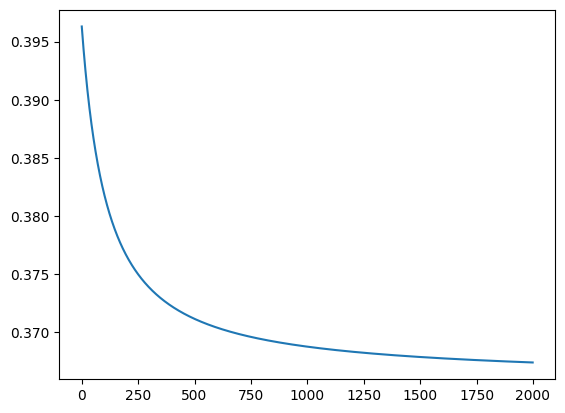

In [342]:
# this will show a very simple decrease, because
# we are not yet stochastically sampling inputs
# (it is always the SAME input! so the network
# only becomes good for that input)
plt.plot(costs)
plt.show()

### Produce random batches: randomly sample a function defined on a 2D square

In [343]:
# For a change: Set up rectified linear units (relu) 
# instead of sigmoid
def net_f_df(z): # calculate f(z) and f'(z)
    val=z*(z>0)
    return(val,z>0) # return both f and f'

In [344]:
# set up all the weights and biases

NumLayers=2 # does not count input-layer (but does count output)
LayerSizes=[2,500,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

In [345]:
# define the batchsize
batchsize=1000

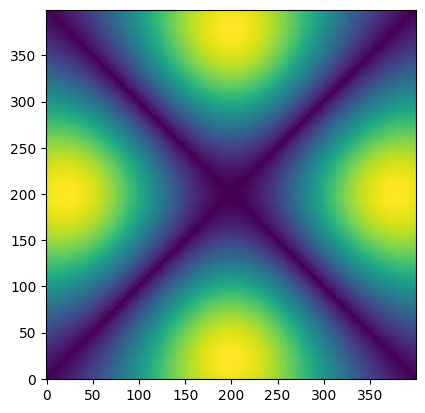

In [346]:
def myFunc(x0,x1):
    r2=x0**2+x1**2
    #val=np.sin(r2)
    val=(exp(-5*r2)*abs(x0+x1)*abs(x0-x1))
    #val=(np.exp(-5*r2)*abs(x1+x0)*abs(x0-x1)*abs(x0)*abs(x1))
    return(val)

xrange=linspace(-0.5,0.5,400)
X0,X1=meshgrid(xrange,xrange)
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower')
plt.show()

In [347]:
def make_batch():
    global batchsize

    inputs=random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets=zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
    return(inputs,targets)

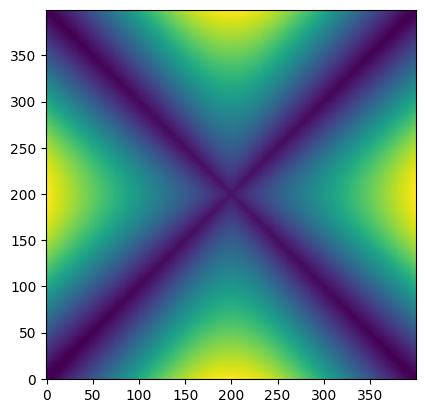

In [350]:
# try to evaluate the (randomly initialized) network
# on some area in the 2D plane
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

testoutput=apply_net_simple(testsample)
myim=plt.imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='none')
plt.show()

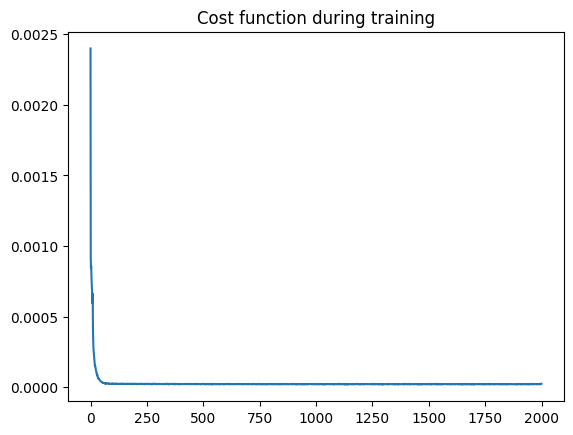

In [349]:
# now train on randomly sampled points
# to make the network reproduce better and
# better this 2D function!
eta=.005
batches=2000
costs=zeros(batches)

for k in range(batches):
    y_in,y_target=make_batch()
    costs[k]=train_net(y_in,y_target,eta)

plt.plot(costs)
plt.title("Cost function during training")
plt.show()


# Animate the network results during training

# start fresh:

# set up all the weights and biases

NumLayers=2 # does not count input-layer (but does count output)
LayerSizes=[2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# import functions for updating display 
# (simple animation)
from IPython.display import clear_output
from time import sleep

eta=0.01 # learning rate
nsteps=10

costs=zeros(nsteps)
for j in range(nsteps):
    clear_output(wait=True)
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4)) # prepare figure
    ax[1].axis('off') # no axes
    
    # the crucial lines:
    y_in,y_target=make_batch() # random samples (points in 2D)
    costs[j]=train_net(y_in,y_target,eta) # train network (one step, on this batch)
    testoutput=apply_net_simple(testsample) # check the new network output in the plane
    
    img=ax[1].imshow(reshape(testoutput,shape(X0)),interpolation='nearest',origin='lower') # plot image
    ax[0].plot(costs)
    
    ax[0].set_title("Cost during training")
    ax[0].set_xlabel("number of batches")
    ax[1].set_title("Current network prediction")
    plt.show()
    sleep(0.001)